# Robustness Analysis: Adjoint and Toggle-Frame Objectives Subject to Either Multiplicative or Additive Errors

This notebook compares the performance of the adjoint and toggling-frame robustness objectives for multiplicative and additive error terms in the system's Hamiltonian. 

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__)
Pkg.instantiate();
# Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using NamedTrajectories
using Statistics
using CairoMakie
using Random
using ColorSchemes
using Makie
using Printf

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651


In [2]:
# Problem parameters
T = 20
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)

QuantumSystem: levels = 2, n_drives = 3

In [3]:
typeof(basis)

UndefVarError: UndefVarError: `basis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing QuantumToolbox in the current active module Main

sanity checks for our good ole adjoint

In [4]:
Random.seed!(5)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
basis = [PAULIS.X, PAULIS.Y, PAULIS.Z]

# fast uni test
funi_prob = UnitaryUniversalProblem(
    sys, U_goal, T, Δt;
    activate_lightspeed=true,
    basis=basis,
    toggle=true,
    piccolo_options=piccolo_opts
    )
solve!(funi_prob, max_iter=200, print_level=5, options=IpoptOptions(eval_hessian=false))
solve!(funi_prob, max_iter=50, print_level=5)

#reg uni
uni_prob = UnitaryUniversalProblem(
    sys, U_goal, T, Δt;
    activate_hyperspeed=true,
    piccolo_options=piccolo_opts
    )
solve!(uni_prob, max_iter=200, print_level=5, options=IpoptOptions(eval_hessian=false))
solve!(uni_prob, max_iter=50, print_level=5)

#Toggling
fast_tog_prob = UnitaryToggleProblem(
    sys, U_goal, T, Δt, Hₑ_add;
    piccolo_options=piccolo_opts
    )
solve!(fast_tog_prob, max_iter=200, print_level=5, options=IpoptOptions(eval_hessian=false))
solve!(fast_tog_prob, max_iter=50, print_level=5)


base_tog_prob = UnitarySmoothPulseProblem(
    sys, U_goal, T, Δt;
    activate_rob_loss=true,
    H_err=Hₑ_add,
    piccolo_options=piccolo_opts
    )
solve!(base_tog_prob, max_iter=200, print_level=5, options=IpoptOptions(eval_hessian=false))
solve!(base_tog_prob, max_iter=50, print_level=5)

def = UnitarySmoothPulseProblem(
    sys, U_goal, T, Δt;
    piccolo_options=piccolo_opts
    )
solve!(def, max_iter=250, print_level=5)

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:     2376
Number of nonzeros in inequality constraint Jacobian.:        0
Number of no

In [5]:
methods(UnitaryToggleProblem)


# 2 methods for generic function "UnitaryToggleProblem" from QuantumCollocation.ProblemTemplates:
 [1] UnitaryToggleProblem(H_drift::AbstractMatrix{<:Number}, H_drives::Vector{<:AbstractMatrix{<:Number}}, args...; kwargs...)
     @ ~/Documents/research/pulses/project/QuantumCollocation.jl/src/problem_templates/unitary_toggle_problem.jl:162
 [2] UnitaryToggleProblem(system::AbstractQuantumSystem, goal::AbstractPiccoloOperator, T::Int64, Δt::Union{Float64, AbstractVector{Float64}}, H_err::Function; unitary_integrator, state_name, control_name, timestep_name, init_trajectory, a_guess, a_bound, a_bounds, da_bound, da_bounds, dda_bound, dda_bounds, Δt_min, Δt_max, Q, Q_t, R, R_a, R_da, R_dda, constraints, piccolo_options)
     @ ~/Documents/research/pulses/project/QuantumCollocation.jl/src/problem_templates/unitary_toggle_problem.jl:70

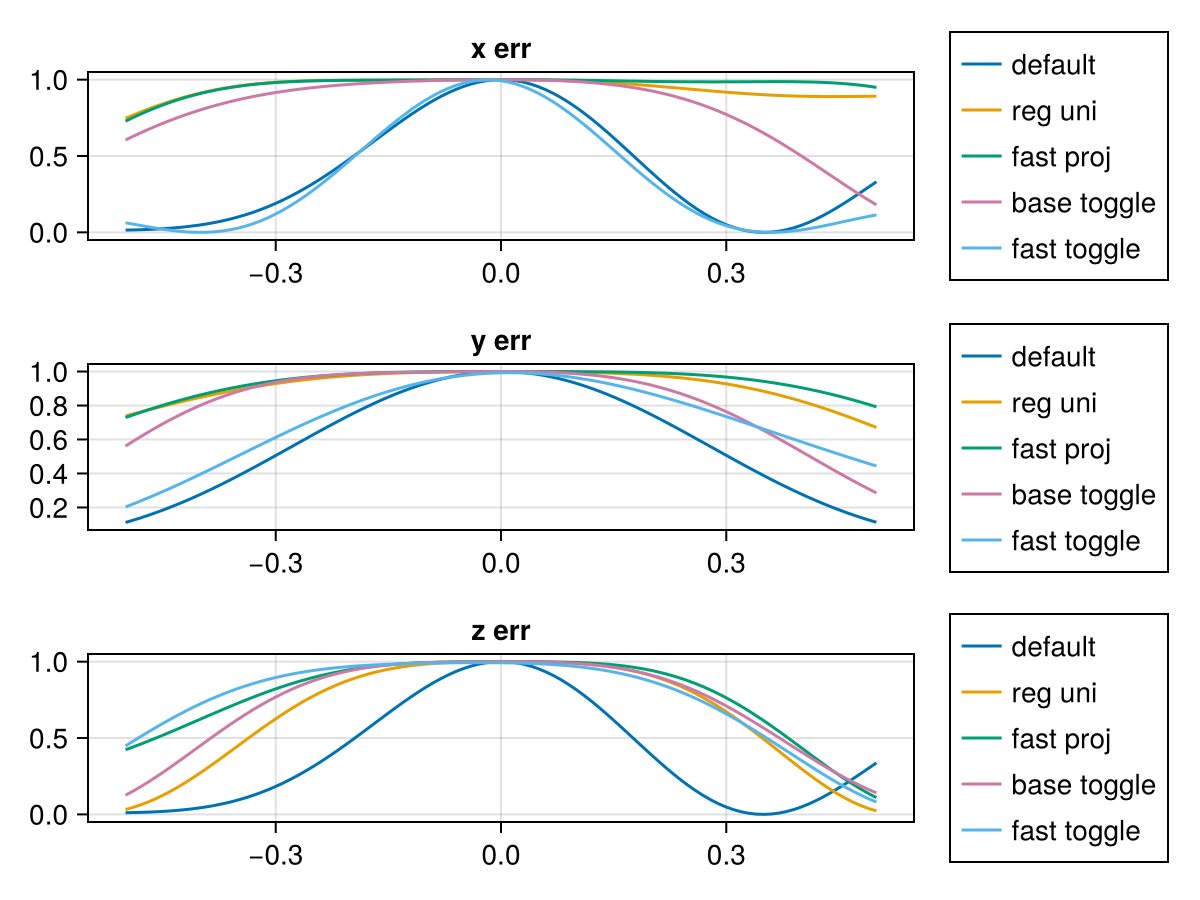

In [10]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1], title="x err")
ax2 = Axis(f[2, 1], title="y err")
ax3 = Axis(f[3, 1], title="z err")

colors = Makie.wong_colors()

εs = -0.5:0.01:.5

# default case (smooth, non-variational, w/o toggling obj)

ys = [unitary_rollout_fidelity(def.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="default", color=colors[1], linestyle=:solid)

# reg uni
ys = [unitary_rollout_fidelity(uni_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="reg uni", color=colors[2], linestyle=:solid)

# fast proj
ys = [unitary_rollout_fidelity(funi_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="fast proj", color=colors[3], linestyle=:solid)

# tog
ys = [unitary_rollout_fidelity(base_tog_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="base toggle", color=colors[4], linestyle=:solid)

# fast tpg
ys = [unitary_rollout_fidelity(fast_tog_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="fast toggle", color=colors[5], linestyle=:solid)


# default case (smooth, non-variational, w/o toggling obj)
ys = [unitary_rollout_fidelity(def.trajectory, QuantumSystem(ε * PAULIS.Y, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)

# reg uni
ys = [unitary_rollout_fidelity(uni_prob.trajectory, QuantumSystem(ε * PAULIS.Y, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax2, εs, ys, label="reg uni", color=colors[2], linestyle=:solid)

# fast proj
ys = [unitary_rollout_fidelity(funi_prob.trajectory, QuantumSystem(ε * PAULIS.Y, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax2, εs, ys, label="fast proj", color=colors[3], linestyle=:solid)

# tog
ys = [unitary_rollout_fidelity(base_tog_prob.trajectory, QuantumSystem(ε * PAULIS.Y, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax2, εs, ys, label="base toggle", color=colors[4], linestyle=:solid)

# fast tpg
ys = [unitary_rollout_fidelity(fast_tog_prob.trajectory, QuantumSystem(ε * PAULIS.Y, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax2, εs, ys, label="fast toggle", color=colors[5], linestyle=:solid)



# default case (smooth, non-variational, w/o toggling obj)
ys = [unitary_rollout_fidelity(def.trajectory, QuantumSystem(ε * PAULIS.Z, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax3, εs, ys, label="default", color=colors[1], linestyle=:solid)

# reg uni
ys = [unitary_rollout_fidelity(uni_prob.trajectory, QuantumSystem(ε * PAULIS.Z, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax3, εs, ys, label="reg uni", color=colors[2], linestyle=:solid)

# fast proj
ys = [unitary_rollout_fidelity(funi_prob.trajectory, QuantumSystem(ε * PAULIS.Z, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax3, εs, ys, label="fast proj", color=colors[3], linestyle=:solid)

# tog
ys = [unitary_rollout_fidelity(base_tog_prob.trajectory, QuantumSystem(ε * PAULIS.Z, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax3, εs, ys, label="base toggle", color=colors[4], linestyle=:solid)

# fast tpg
ys = [unitary_rollout_fidelity(fast_tog_prob.trajectory, QuantumSystem(ε * PAULIS.Z, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax3, εs, ys, label="fast toggle", color=colors[5], linestyle=:solid)



Legend(f[1,2], ax1, position=:lb)
Legend(f[2,2], ax2, position=:lb)
Legend(f[3,2], ax2, position=:lb)

f


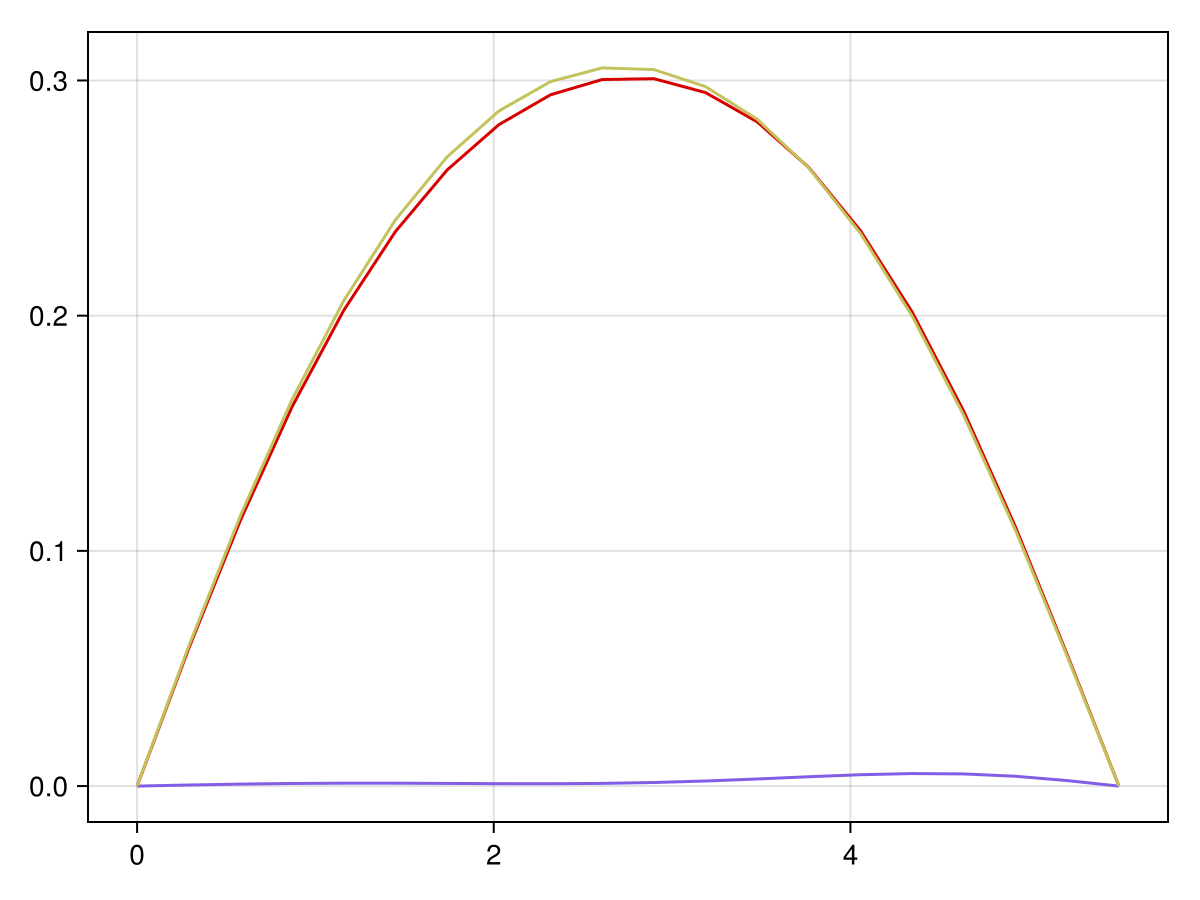

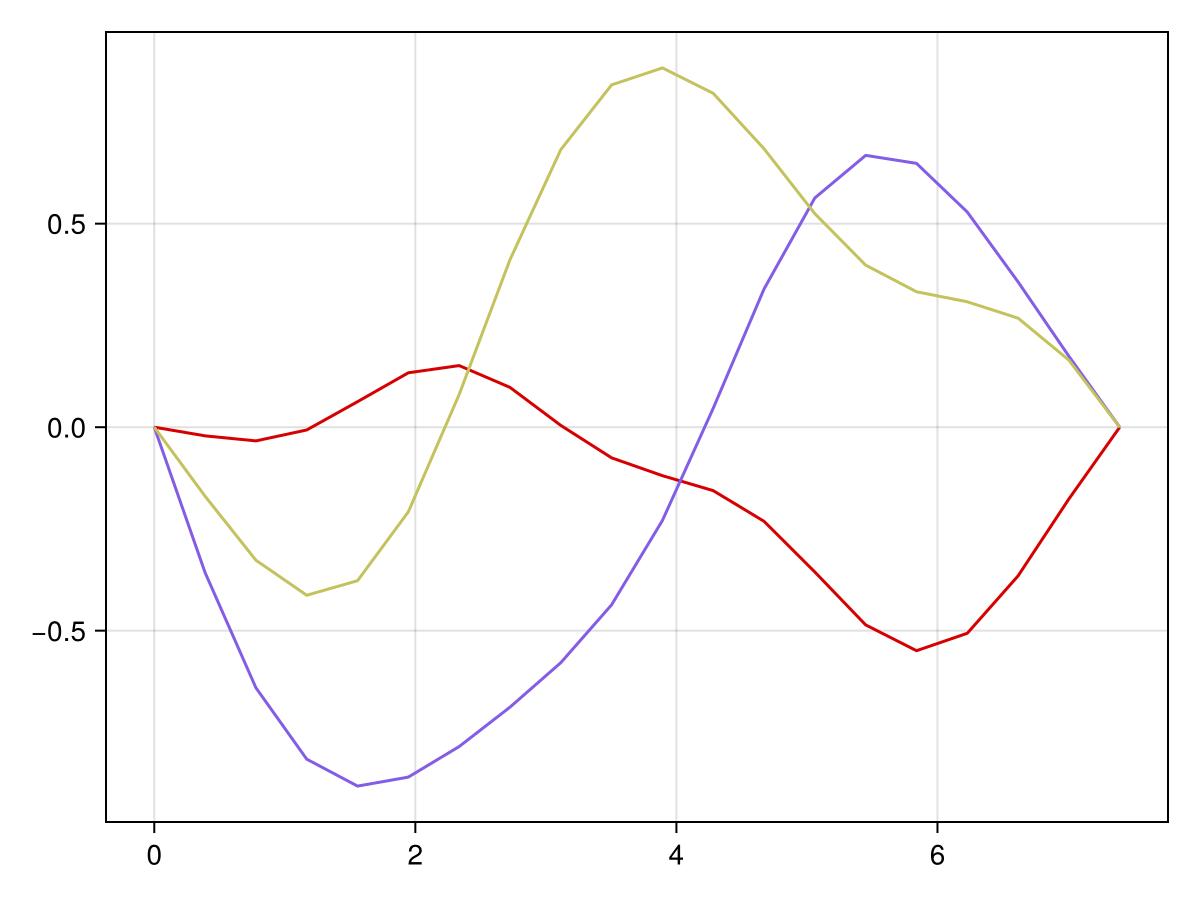

UndefVarError: UndefVarError: `mult_prob` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [7]:
display(CairoMakie.plot(def.trajectory, :a))
display(CairoMakie.plot(base_tog_prob.trajectory, :a))
display(CairoMakie.plot(mult_prob.trajectory, :a))
display(CairoMakie.plot(both_prob.trajectory, :a))

In [8]:
# H_drive_add = H_drive

# f = Figure()
# ax1 = Axis(f[1, 1], title="additive")
# ax2 = Axis(f[2, 1], title="multiplicative")

# colors = Makie.wong_colors()

# εs = 0:0.01:.5

# # default case (smooth, non-variational, w/o toggling obj)

# ys = [unitary_rollout_fidelity(def.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
# lines!(ax1, εs, ys, label="default", color=colors[1], linestyle=:solid)

# ys = [unitary_rollout_fidelity(def.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)

# # toggling obj

# # (add)
# ys = [unitary_rollout_fidelity(base_tog_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
# lines!(ax1, εs, ys, label="add toggle", color=colors[2], linestyle=:solid)

# ys = [unitary_rollout_fidelity(base_tog_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="add toggle", color=colors[2], linestyle=:solid)

# # (mult)
# ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
# lines!(ax1, εs, ys, label="mult toggle", color=colors[3], linestyle=:solid)

# ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="mult toggle", color=colors[3], linestyle=:solid)

# # (both)
# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
# lines!(ax1, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

# # adjoint obj

# # (add)
# ys = [unitary_rollout_fidelity(varbase_tog_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
# lines!(ax1, εs, ys, label="add adjoint", color=colors[6], linestyle=:solid)

# ys = [unitary_rollout_fidelity(varbase_tog_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="add adjoint", color=colors[6], linestyle=:solid)

# # (mult)
# ys = [unitary_rollout_fidelity(varmult_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
# lines!(ax1, εs, ys, label="mult adjoint", color=colors[7], linestyle=:solid)

# ys = [unitary_rollout_fidelity(varmult_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="mult adjoint", color=colors[7], linestyle=:solid)

# # (both)
# ys = [unitary_rollout_fidelity(varboth_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
# lines!(ax1, εs, ys, label="both adjoint", color=colors[5], linestyle=:solid)

# ys = [unitary_rollout_fidelity(varboth_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="both adjoint", color=colors[5], linestyle=:solid)


# Legend(f[1,2], ax1, position=:lb)
# Legend(f[2,2], ax2, position=:lb)

# f
